## Problem Statement

We are having Housing Finance company and wants to automate the loan eligibility process based on customer detail provided while filling online application form.

## About the Data Set

**Loan_ID:**           Unique Loan ID <br>

**Gender:**	           Male/ Female <br>

**Married:**	       Applicant married (Y/N) <br>

**Dependents:**	       Number of dependents <br>

**Education:**	       Applicant Education (Graduate/ Under Graduate) <br>

**Self_Employed:**	   Self employed (Y/N) <br>

**ApplicantIncome:**   Applicant income <br>

**CoapplicantIncome:** Coapplicant income <br>

**LoanAmount:**	       Loan amount in thousands <br>

**Loan_Amount_Term:**  Term of loan in months <br>

**Credit_History:**	   Credit history meets guidelines <br>

**Property_Area:**	   Urban/ Semi Urban/ Rural <br>

**Loan_Status:**	   (Output Variable) Loan approved (Y/N) <br>


### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None  
pd.options.display.float_format = '{:.6f}'.format
from sklearn.model_selection import train_test_split
import statsmodels
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import pydotplus
from IPython.display import Image
from imblearn.over_sampling import SMOTE
import scikitplot as skplt

## Table of Content

1. **[Data Preprocessing](#dp)**
    - 1.1 - **[Analysis on Categorical Independent Variable vs Target Variable](#an)**
    - 1.2 - **[Remove Insignificant Variables](#rem)**
    - 1.3 - **[Missing Value Treatment](#mis)**
    - 1.4 - **[Outlier Treatment](#out)**
    - 1.5 - **[Encode the Categorical Variables](#enc)**
    - 1.6 - **[Correlation between all the numerical variables](#cor)**
    - 1.7 - **[Distribution of Dependent variable](#ddv)**
    - 1.8 - **[Synthetic Minority Oversampling Technique (SMOTE) for Balancing Data](#smote)**
    - 1.9 - **[Train-Test Split](#tt)**
2. **[Logistic Regression](#lr)**
3. **[KNN](#knn)**
4. **[Decision Tree](#dt)**
5. **[Random Forest](#rf)**
6. **[Conclusion](#cn)**

### Load the data

In [2]:
# load the data
df_loan = pd.read_csv('loan_data_set.csv')

In [3]:
df_loan.shape

(614, 13)

In [4]:
df_loan.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

We can see, The data has 614 observations and 13 variables. And out of 13 we have 8 categorical variable and 5 numeric variables. <br> All the variables have the correct data type.

In [5]:
df_loan.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.000000,nan,360.000000,1.000000,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.000000,128.000000,360.000000,1.000000,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.000000,66.000000,360.000000,1.000000,Urban,Y


<a id="dp"> </a>
## 1. Data Preprocessing

<a id="an"> </a>
### 1.1 Analysis on Categorical Independent Variable vs Target Variable

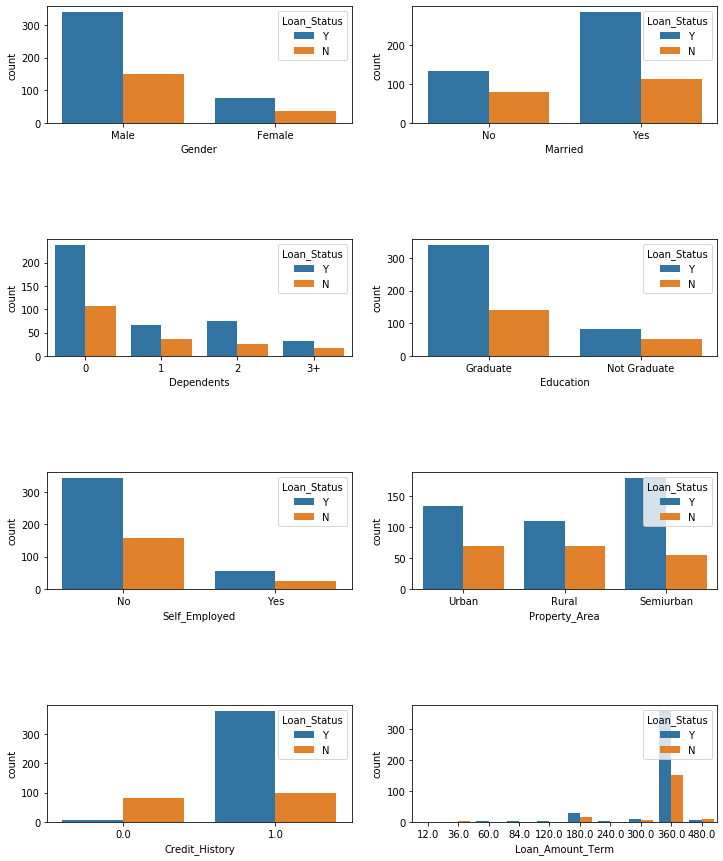

In [6]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History',
                       'Loan_Amount_Term']
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df_loan,hue='Loan_Status',ax=axes[row,col])
plt.subplots_adjust(hspace=1)


<ol>
<li>The proportion of married applicants is higher for approved loans.</li>
<li>Distribution of applicants with 1 or 3+ dependents is similar across both the categories of Loan_Status.</li>
<li>There is nothing significant we can infer from Self_Employed vs Loan_Status plot.</li>
<li>It seems people with a credit history as 1 are more likely to get their loans approved.</li>
<li>The proportion of loans getting approved in the semi-urban area is higher as compared to that in rural or urban areas.</li>
</ol>

<a id="rem"> </a>
### 1.2 Remove Insignificant Variables

The column Loan_ID contains the serial number of the Applicant, which is redundant for further analysis. Thus, we drop the column.

In [7]:
df_loan = df_loan.drop('Loan_ID', axis = 1)

<a id="mis"> </a>
### 1.3 Missing Value Treatment

In [8]:
df_loan.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
df_loan["Loan_Amount_Term"].value_counts()

360.000000    512
180.000000     44
480.000000     15
300.000000     13
84.000000       4
240.000000      4
120.000000      3
36.000000       2
60.000000       2
12.000000       1
Name: Loan_Amount_Term, dtype: int64

Loan_Amount_Term is numerical variable, the value of 360 is repeating the most. So we will replace the missing values in this variable using the mode of this variable

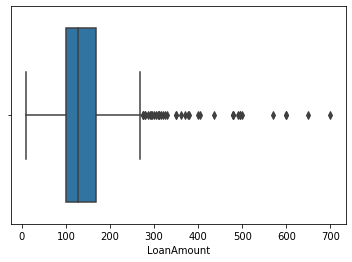

In [10]:
sns.boxplot(df_loan["LoanAmount"])

We will use the median to fill the null values as we see that the loan amount has outliers so the mean will not be the proper approach as it is highly affected by the presence of outliers.

In [11]:
# Categorical variables
df_loan["Gender"].fillna(df_loan["Gender"].mode()[0], inplace=True)
df_loan["Married"].fillna(df_loan["Married"].mode()[0], inplace=True)
df_loan["Dependents"].fillna(df_loan["Dependents"].mode()[0], inplace=True)
df_loan["Self_Employed"].fillna(df_loan["Self_Employed"].mode()[0], inplace=True)
df_loan["Credit_History"].fillna(df_loan["Credit_History"].mode()[0], inplace=True)
df_loan["Loan_Amount_Term"].fillna(df_loan["Loan_Amount_Term"].mode()[0], inplace=True)

# Numeric variables
df_loan["LoanAmount"] = df_loan["LoanAmount"].fillna(df_loan["LoanAmount"].median())

df_loan.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<a id="out"> </a>
### 1.4 Outlier Treatment

ApplicantIncome :


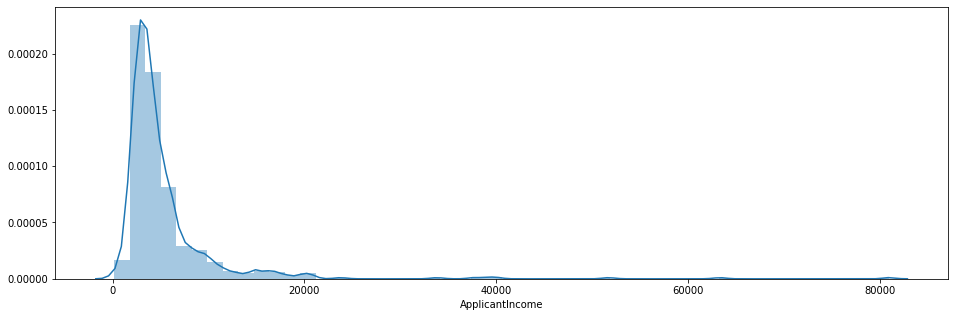

CoapplicantIncome :


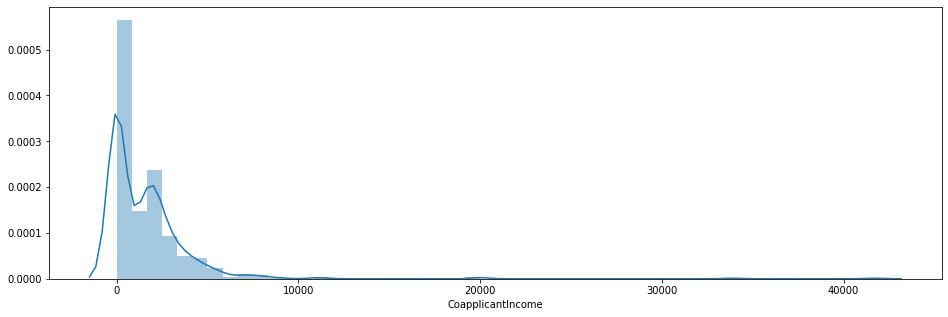

LoanAmount :


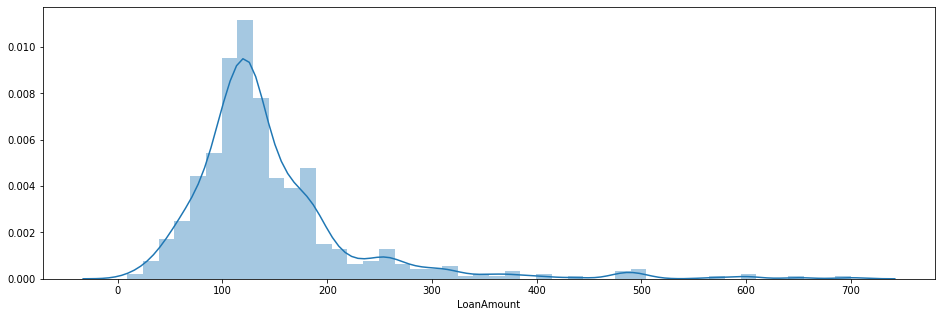

In [12]:
numericVariables = ['ApplicantIncome','CoapplicantIncome','LoanAmount']

for var in numericVariables:
    plt.figure(figsize=(16,5))
    print(var,':')
    sns.distplot(df_loan[var])
    plt.show()

The variables are not normally distributed

Due to these outliers bulk of the data in the loan amount is at the left and the right tail is longer. This is called right skewness. One way to remove the skewness is by doing the log transformation. As we take the log transformation, it does not affect the smaller values much but reduces the larger values. So, we get a distribution similar to normal distribution.
Let’s visualize the effect of log transformation.

Made an assumption that some people might have a low income but strong CoappliantIncome so a good idea is to combine them in a TotalIncome column. And dropping the coapplicantIncome variable

ApplicantIncome :


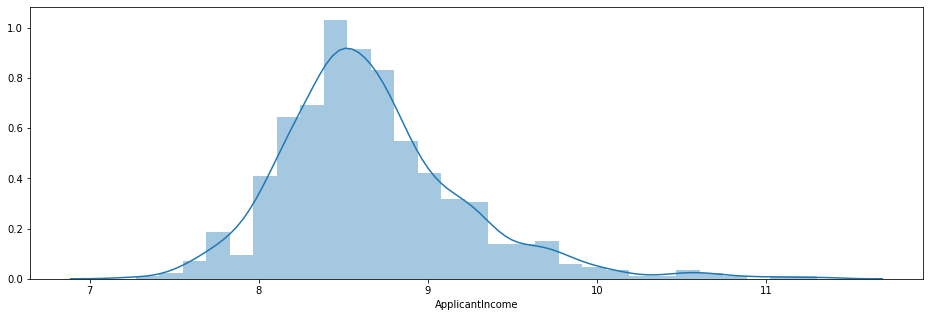

LoanAmount :


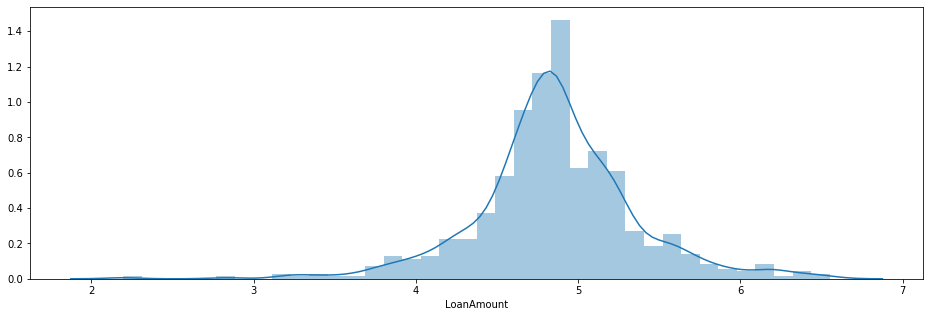

In [13]:
#combine ApplicantIncome and CoapplicantIncome, and dropping CoapplicantIncome

#log tranformation for Applicantincome
df_loan['ApplicantIncome'] = np.log(df_loan['ApplicantIncome'] + df_loan['CoapplicantIncome'] )
df_loan = df_loan.drop('CoapplicantIncome',axis=1)

#log tranformation for loan amount
df_loan['LoanAmount'] = np.log(df_loan['LoanAmount'])

numericVariables_log = ['ApplicantIncome', 'LoanAmount']

for var in numericVariables_log:
    plt.figure(figsize=(16,5))
    print(var,':')
    sns.distplot(df_loan[var])
    plt.show()

<a id="enc"> </a>
### 1.5 Encode the Categorical Variables

In [14]:
categoricalVariables = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
for var in categoricalVariables:
    print(df_loan[var].unique())

['Male' 'Female']
['No' 'Yes']
['0' '1' '2' '3+']
['Graduate' 'Not Graduate']
['No' 'Yes']
['Urban' 'Rural' 'Semiurban']
['Y' 'N']


In [15]:
from sklearn.preprocessing import LabelEncoder
category= ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status'] 
encoder= LabelEncoder()
for i in category:
    df_loan[i] = encoder.fit_transform(df_loan[i])
df_loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,8.674026,4.852030,360.000000,1.000000,2,1
1,1,1,1,0,0,8.714568,4.852030,360.000000,1.000000,0,0
2,1,1,0,0,1,8.006368,4.189655,360.000000,1.000000,2,1
3,1,1,0,1,0,8.505323,4.787492,360.000000,1.000000,2,1
4,1,0,0,0,0,8.699515,4.948760,360.000000,1.000000,2,1


<a id="cor"> </a>
### 1.6 Correlation between all the numerical variables

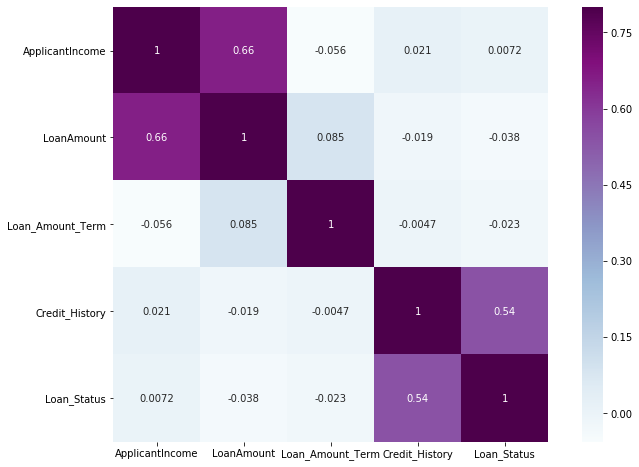

In [16]:
dataNumeric = pd.DataFrame(df_loan, columns=['ApplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Loan_Status'])
matrix = dataNumeric.corr()
f, ax = plt.subplots(figsize=(12,8))
sns.heatmap(matrix,vmax=.8,square=True,cmap='BuPu', annot = True)

We see that the most correlate variables are ApplicantIncome — LoanAmount and Credit_History — Loan_Status.

### Create a generalized function to calculate the performance metrics for the test set.

In [17]:
# define a function to plot the ROC curve and print the ROC-AUC score
def plot_roc(model):
    
    # predict the probability of target variable using X_test
    # consider the probability of positive class by subsetting with '[:,1]'
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Loan Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)

In [18]:
df_input = df_loan.drop('Loan_Status', axis=1)

df_target = df_loan['Loan_Status']

<a id="ddv"> </a>
### 1.7 Distribution of Dependent variable

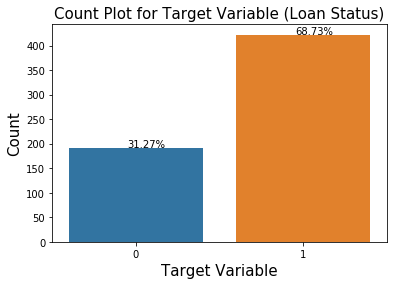

In [19]:
# plot the countplot of the variable 'Loan Status'
sns.countplot(x = df_target)

# 'x' and 'y' gives position of the text
# 's' is the text 
plt.text(x = -0.05, y = df_target.value_counts()[0] + 1, s = str(round((df_target.value_counts()[0])*100/len(df_target),2)) +
         '%')
plt.text(x = 0.95, y = df_target.value_counts()[1] +1, s = str(round((df_target.value_counts()[1])*100/len(df_target),2)) +
         '%')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Count Plot for Target Variable (Loan Status)', fontsize = 15)
plt.xlabel('Target Variable', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

# to show the plot
plt.show()

<a id="smote"> </a>
### 1.8 Synthetic Minority Oversampling Technique (SMOTE) for Balancing Data

In [20]:
from imblearn.over_sampling import SMOTE

# for reproducibility purposes
seed = 100
k = 5
sm = SMOTE(sampling_strategy='all', k_neighbors=k, random_state=seed)
x_bal, y_bal = sm.fit_resample(df_input, df_target)

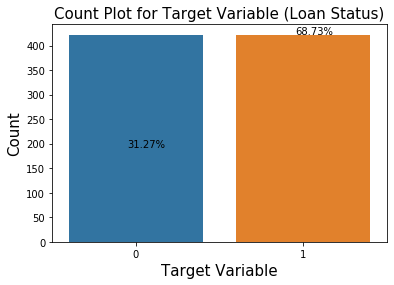

In [21]:
sns.countplot(x = y_bal)
# 'x' and 'y' gives position of the text
# 's' is the text 
plt.text(x = -0.05, y = df_target.value_counts()[0] + 1, s = str(round((df_target.value_counts()[0])*100/len(df_target),2)) +
         '%')
plt.text(x = 0.95, y = df_target.value_counts()[1] +1, s = str(round((df_target.value_counts()[1])*100/len(df_target),2)) +
         '%')
# add plot and axes labels
# set text size using 'fontsize'
plt.title('Count Plot for Target Variable (Loan Status)', fontsize = 15)
plt.xlabel('Target Variable', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

# to show the plot
plt.show()

In [22]:
df_target = pd.DataFrame(df_target)

In [23]:
df_input = pd.DataFrame(x_bal, columns=df_input.columns)
df_target = pd.DataFrame(y_bal, columns= df_target.columns)

<a id="tt"> </a>
### 1.9 Train-Test Split

In [24]:
# split data into train subset and test subset
# set 'random_state' to generate the same dataset each time you run the code 
# 'test_size' returns the proportion of data to be included in the testing set
X_train, X_test, y_train, y_test = train_test_split(df_input, df_target, random_state = 10, test_size = 0.3)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (590, 10)
y_train (590, 1)
X_test (254, 10)
y_test (254, 1)


<a id="lr"> </a>
## 2. Logistic Regression

#### Build a full logistic model on a training dataset

In [25]:
logReg = LogisticRegression()

logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predictions on the test set.

In [26]:
y_pred = logReg.predict(X_test)

#### Plot the confusion matrix.

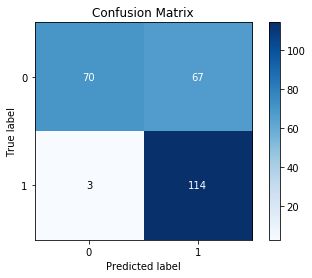

In [27]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

#### Compute performance metrics

In [28]:
# compute the performance measures on train data
test_pred = logReg.predict(X_test)

# return the performace measures on train set
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.51      0.67       137
           1       0.63      0.97      0.77       117

    accuracy                           0.72       254
   macro avg       0.79      0.74      0.72       254
weighted avg       0.81      0.72      0.71       254



#### Plot the ROC curve

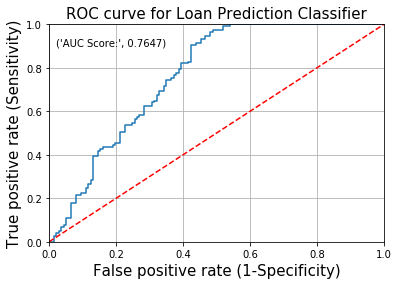

In [29]:
plot_roc(logReg)

**Interpretation:** Using logistic regression, we are getting 72% accuracy.

<a id="knn"> </a>
## 4. K Nearest Neighbors (KNN)

#### Build a knn model on a training dataset using euclidean distance

In [30]:
# instantiate the 'KNeighborsClassifier'
# n_neighnors: number of neighbors to consider
# default metric is minkowski, and with p=2 it is equivalent to the euclidean metric
knn_classification = KNeighborsClassifier(n_neighbors = 5)

# fit the model using fit() on train data
knn_model = knn_classification.fit(X_train, y_train)

#### Predictions on the test set.

In [31]:
y_pred_knn = knn_model.predict(X_test)

#### Plot the confusion matrix.

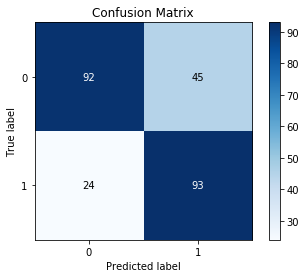

In [32]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_knn)

#### Compute performance metrics

In [33]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73       137
           1       0.67      0.79      0.73       117

    accuracy                           0.73       254
   macro avg       0.73      0.73      0.73       254
weighted avg       0.74      0.73      0.73       254



#### Plot the ROC curve

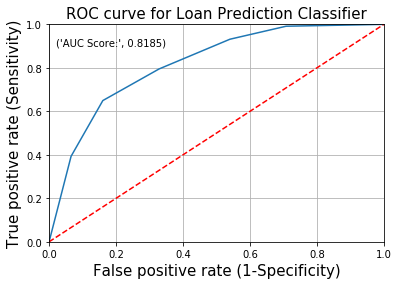

In [34]:
plot_roc(knn_model)

####  Optimal Value of K (using GridSearchCV)

In [35]:
# create a dictionary with hyperparameters and its values
# n_neighnors: number of neighbors to consider
# usually, we consider the odd value of 'n_neighnors' to avoid the equal number of nearest points with more than one class
# pass the different distance metrics to the parameter, 'metric'
tuned_paramaters = {'n_neighbors': np.arange(1, 25, 2),
                   'metric': ['hamming','euclidean','manhattan']}
 
# instantiate the 'KNeighborsClassifier' 
knn_classification = KNeighborsClassifier()

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the knn model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 5
# scoring: pass the scoring parameter 'accuracy'
knn_grid = GridSearchCV(estimator = knn_classification, 
                        param_grid = tuned_paramaters, 
                        cv = 5, 
                        scoring = 'accuracy')

# fit the model on X_train and y_train using fit()
knn_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for KNN Classifier: ', knn_grid.best_params_, '\n')

Best parameters for KNN Classifier:  {'metric': 'euclidean', 'n_neighbors': 1} 



#### Line plot to see the error rate for each value of K using euclidean distance as a metric of KNN model

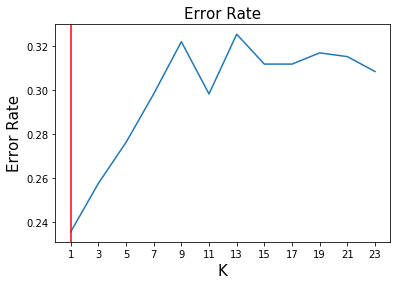

In [36]:
# consider an empty list to store error rate
error_rate = []

# use for loop to build a knn model for each K
for i in np.arange(1,25,2):
    
    # setup a knn classifier with k neighbors
    # use the 'euclidean' metric 
    knn = KNeighborsClassifier(i, metric = 'euclidean')
   
    # fit the model using 'cross_val_score'
    # pass the knn model as 'estimator'
    # use 5-fold cross validation
    score = cross_val_score(knn, X_train, y_train, cv = 5)
    
    # calculate the mean score
    score = score.mean()
    
    # compute error rate 
    error_rate.append(1 - score)

# plot the error_rate for different values of K 
plt.plot(range(1,25,2), error_rate)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Error Rate', fontsize = 15)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)

# set the x-axis labels
plt.xticks(np.arange(1, 25, step = 2))

# plot a vertical line across the minimum error rate
plt.axvline(x = 1, color = 'red')

# display the plot
plt.show()

We can see that the optimal value of K (= 1) obtained from the GridSearchCV() results in a lowest error rate.

#### Build the model using the optimal values

In [37]:
knn_classification = KNeighborsClassifier(n_neighbors = 1, p=2)

# fit the model using fit() on train data
knn_model_cv = knn_classification.fit(X_train, y_train)

In [38]:
y_pred_knn_grid = knn_model_cv.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_knn_grid))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       137
           1       0.75      0.79      0.77       117

    accuracy                           0.78       254
   macro avg       0.78      0.78      0.78       254
weighted avg       0.79      0.78      0.78       254



**Interpretation:** Using logistic regression, we are getting 78% accuracy.

<a id="dt"> </a>
## 5. Decision Tree

#### Building a full decision tree model on a train dataset using 'entropy'.

In [40]:
# instantiate the 'DecisionTreeClassifier' object using 'entropy' criterion
# pass the 'random_state' to obtain the same samples for each time you run the code
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

# fit the model using fit() on train data
decision_tree = decision_tree_classification.fit(X_train, y_train)

#### Plot the decision tree

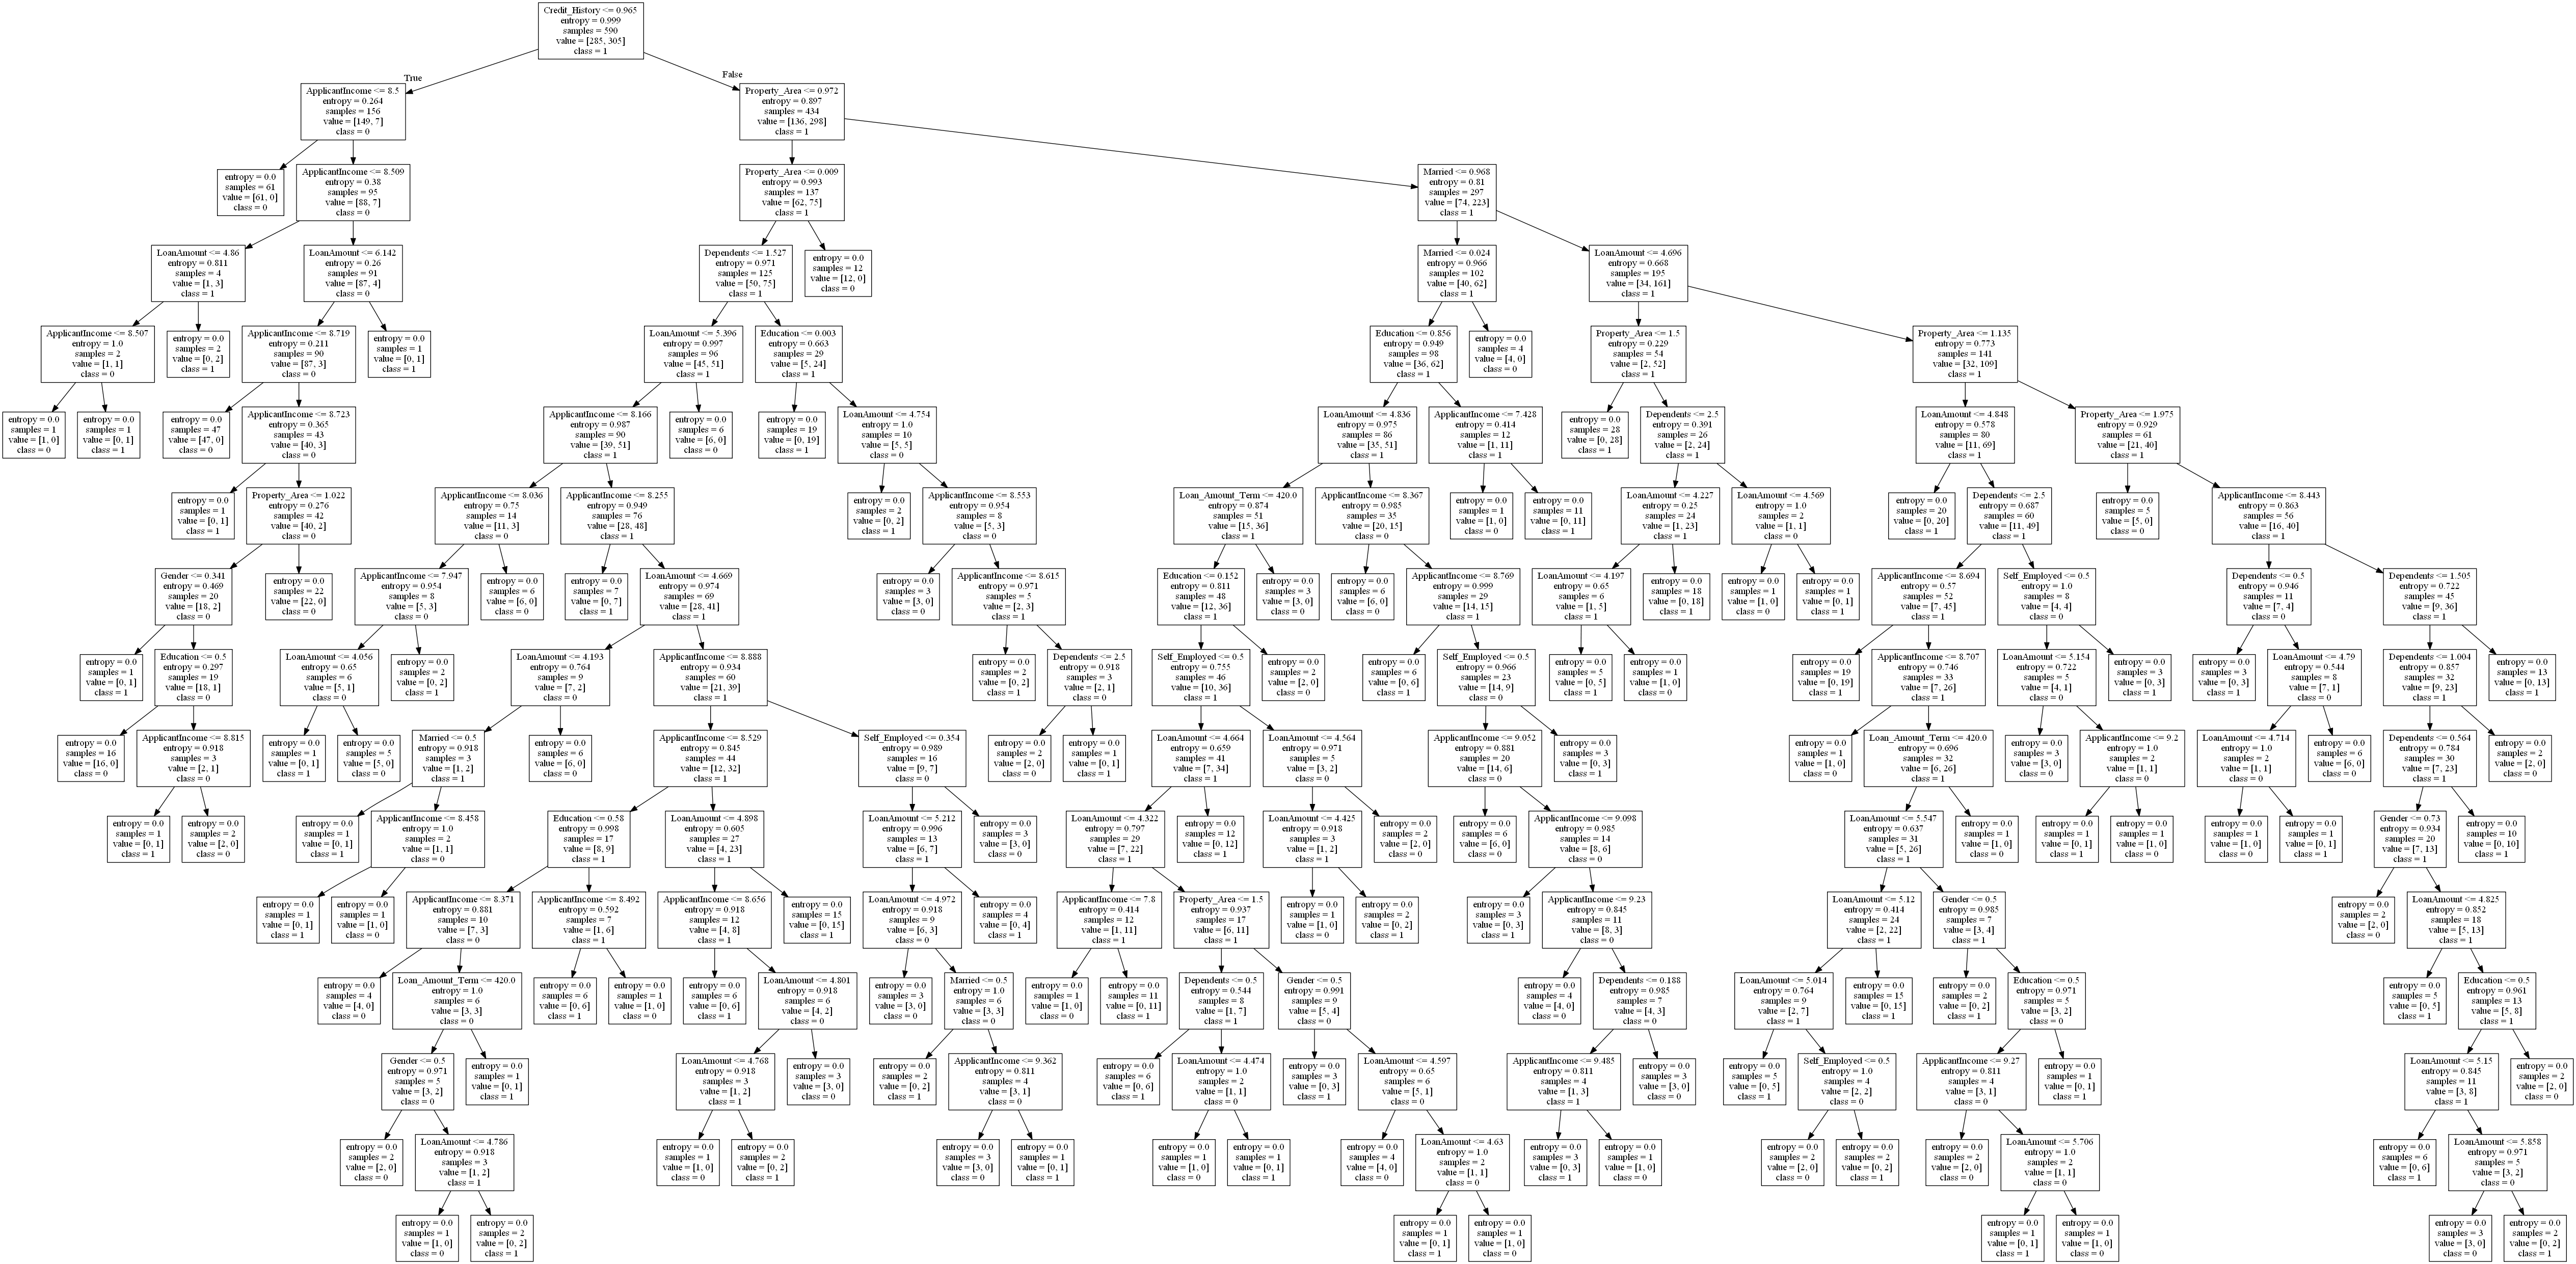

In [41]:
# save the column names in 'labels'
labels = X_train.columns

# export a decision tree in DOT format
# pass the 'decision_tree' to export it to Graphviz
# pass the column names to 'feature_names'
# pass the required class labels to 'class_names'
dot_data = tree.export_graphviz(decision_tree, feature_names = labels, class_names = ["0","1"])  

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)  

# display the decision tree
Image(graph.create_png())

# double-click on the image below to get an expanded view

#### Predictions on the test set.

In [42]:
# compute the performance measures on train data
test_pred_des = decision_tree.predict(X_test)

#### Plot the confusion matrix.

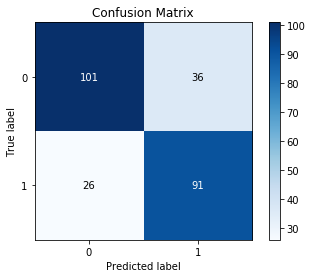

In [43]:
skplt.metrics.plot_confusion_matrix(y_test, test_pred_des)

#### Calculate performance measures on the test set.

In [44]:
print(classification_report(y_test, test_pred_des))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       137
           1       0.72      0.78      0.75       117

    accuracy                           0.76       254
   macro avg       0.76      0.76      0.76       254
weighted avg       0.76      0.76      0.76       254



#### Plot the ROC curve

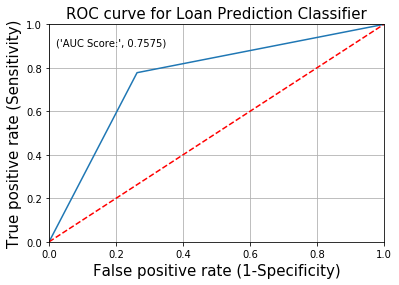

In [45]:
plot_roc(decision_tree)

If we tune the hyperparameters in the decision tree, it helps to avoid the over-fitting of the tree.

#### Tune the Hyperparameters using GridSearchCV (Decision Tree)

In [46]:
# create a dictionary with hyperparameters and its values
# pass the criteria 'entropy' and 'gini' to the parameter, 'criterion' 
# pass the range of values to 'max_depth' that assigns maximum depth of the tree
# 'max_features' assigns maximum number of features to consider for the best split. We pass the string 'sqrt' and 'log2'
# 'sqrt' considers maximum number of features equal to the square root of total features
# 'log2' considers maximum number of features equal to the log of total features with base 2
# pass the range of values to 'min_samples_split' that assigns minimum number of samples to split an internal node
# pass the range of values to 'min_samples_leaf' that assigns minimum number of samples required at the terminal/leaf node
tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"],
                     'min_samples_split': range(2,10),
                     'min_samples_leaf': range(1,10)
                     }]
 
# instantiate the 'DecisionTreeClassifier' 
# pass the 'random_state' to obtain the same samples for each time you run the code
decision_tree_classification = DecisionTreeClassifier(random_state = 10)

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the decision tree classifier model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 5
tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         param_grid = tuned_paramaters, 
                         cv = 5)

# fit the model on X_train and y_train using fit()
tree_grid_model = tree_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9} 



#### Build the model using the tuned hyperparameters.

In [47]:
# instantiate the 'DecisionTreeClassifier'
# 'best_params_' returns the dictionary containing best parameter values and parameter name  
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
dt_model = DecisionTreeClassifier(criterion = tree_grid_model.best_params_.get('criterion'),
                                  max_depth = tree_grid_model.best_params_.get('max_depth'),
                                  max_features = tree_grid_model.best_params_.get('max_features'),
                                  min_samples_leaf = tree_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = tree_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
dt_model = dt_model.fit(X_train, y_train)

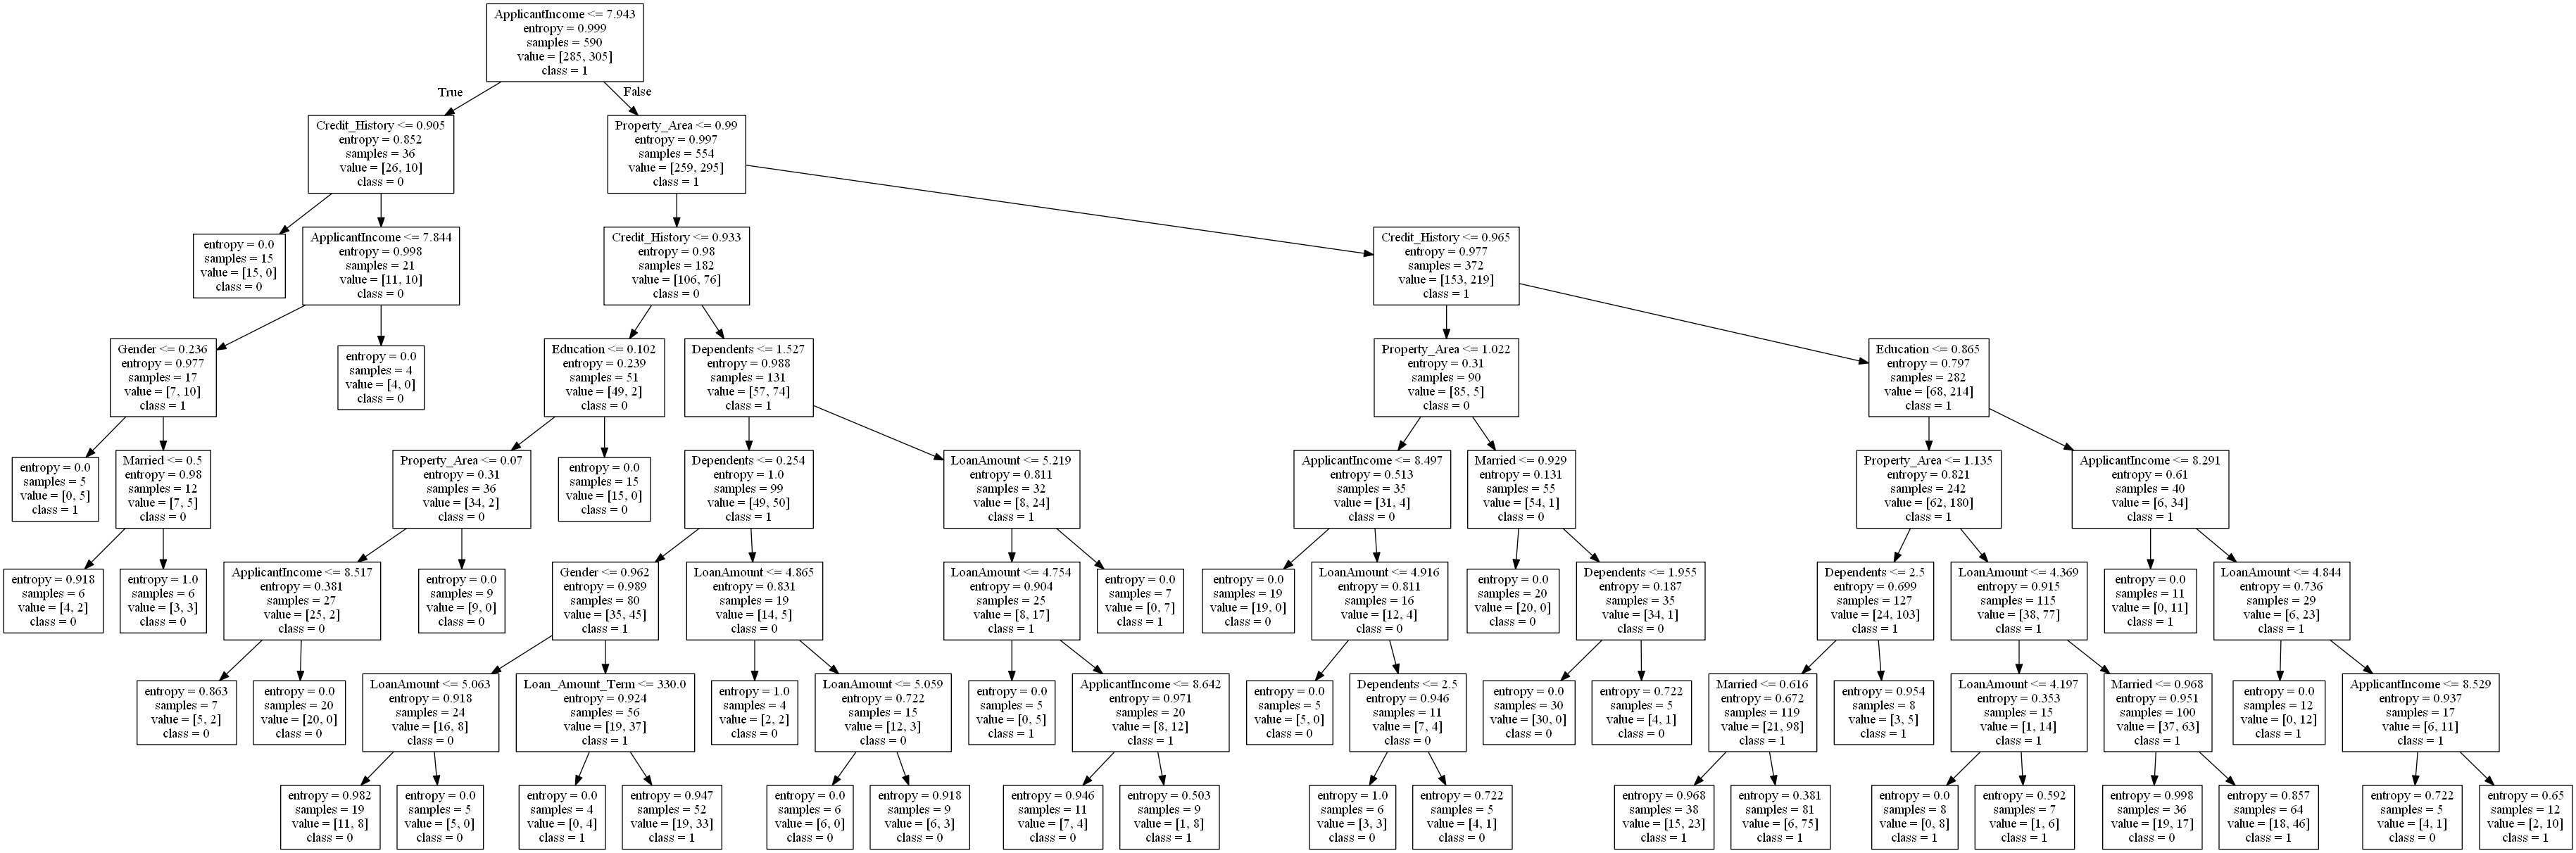

In [48]:
# save the column names in 'labels'
labels = X_train.columns

# export a decision tree in DOT format
# pass the 'dt_model' to export it to Graphviz
# pass the column names to 'feature_names'
# pass the required class labels to 'class_names'
dot_data = tree.export_graphviz(dt_model, feature_names = labels, class_names = ["0","1"])  

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)  

# display the decision tree
Image(graph.create_png())

#### Calculate performance measures on the test set.

In [49]:
# compute the performance measures on train data
test_pred = dt_model.predict(X_test)

# return the performace measures on train set
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       137
           1       0.64      0.85      0.73       117

    accuracy                           0.71       254
   macro avg       0.73      0.72      0.71       254
weighted avg       0.74      0.71      0.71       254



**Interpretation:** Using logistic regression, we are getting 71% accuracy.

<a id="rf"> </a>
## 6. Random Forest

In [50]:
# instantiate the 'RandomForestClassifier'
# pass the required number of trees in the random forest to the parameter, 'n_estimators'
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(X_train, y_train)

#### Predictions on the test set.

In [51]:
y_pred_rf = rf_model.predict(X_test)

#### Plot the confusion matrix.

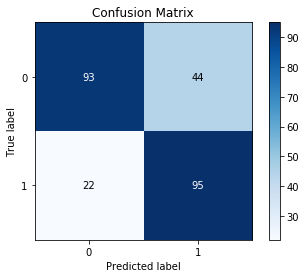

In [52]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf)

#### Compute performance metrics

In [53]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       137
           1       0.68      0.81      0.74       117

    accuracy                           0.74       254
   macro avg       0.75      0.75      0.74       254
weighted avg       0.75      0.74      0.74       254



#### Plot the ROC curve

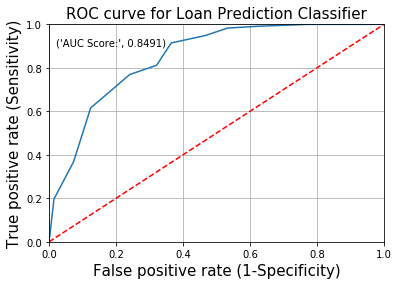

In [54]:
plot_roc(rf_model)

#### Tune the Hyperparameters using GridSearchCV (Random Forest)

In [55]:
# create a dictionary with hyperparameters and its values
# pass the criteria 'entropy' and 'gini' to the parameter, 'criterion' 
# pass a list of values to 'n_estimators' to build the different number of trees in the random forest
# pass a list of values to 'max_depth' that assigns maximum depth of the tree
# 'max_features' assigns maximum number of features to consider for the best split. We pass the string 'sqrt' and 'log2'
# 'sqrt' considers maximum number of features equal to the square root of total features
# 'log2' considers maximum number of features equal to the log of total features with base 2
# pass a list of values to 'min_samples_split' that assigns minimum number of samples to split an internal node
# pass a list of values to 'min_samples_leaf' that assigns minimum number of samples required at the terminal/leaf node
# pass a list of values to 'max_leaf_nodes' that assigns maximum number of leaf nodes in the tree
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 
# instantiate the 'RandomForestClassifier' 
# pass the 'random_state' to obtain the same samples for each time you run the code
random_forest_classification = RandomForestClassifier(random_state = 10)

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the random forest classifier model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 5
rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

# use fit() to fit the model on the train set
rf_grid_model = rf_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} 



#### Build the model using the tuned hyperparameters.

In [56]:
# instantiate the 'RandomForestClassifier'
# 'best_params_' returns the dictionary containing best parameter values and parameter name  
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_model.fit(X_train, y_train)

#### Calculate performance measures on the test set.

In [57]:
# compute the performance measures on train data
test_pred = rf_model.predict(X_test)

# return the performace measures on train set
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.95      0.54      0.69       137
           1       0.64      0.97      0.77       117

    accuracy                           0.74       254
   macro avg       0.80      0.75      0.73       254
weighted avg       0.81      0.74      0.73       254



**Interpretation:** Using logistic regression, we are getting 74% accuracy.

#### Identify the Important Features

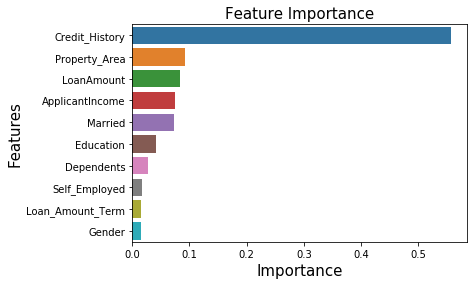

In [58]:
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the gini importance
important_features = pd.DataFrame({'Features': X_train.columns, 
                                   'Importance': rf_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

## Conclusion

In [61]:
Models = [ logReg, knn_model_cv ]

In [62]:
Model_columns = []
Model_compare = pd.DataFrame(columns = Model_columns)

row_index = 0
for alg in Models:  
    
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    Model_name = alg.__class__.__name__
    Model_compare.loc[row_index,'Models'] = Model_name
    Model_compare.loc[row_index, 'Precission'] = precision_score(y_test, predicted)
    Model_compare.loc[row_index, 'Recall'] = recall_score(y_test, predicted)
    Model_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    Model_compare.loc[row_index, 'AUC'] = metrics.auc(fp, tp)

    row_index+=1
    
Model_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
Model_compare

,Models,Precission,Recall,Test Accuracy,AUC
1,KNeighborsClassifier,0.750000,0.794872,0.783500,0.784297
0,LogisticRegression,0.629834,0.974359,0.724400,0.742654


**Interpretation:** We can see from result, KNN model is giving better accuracy and AUC value compare to other models.

In [63]:
import pickle

In [64]:
pickle.dump(knn_classification, open('loanprediction.pkl','wb'))

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590 entries, 635 to 265
Data columns (total 10 columns):
Gender              590 non-null float64
Married             590 non-null float64
Dependents          590 non-null float64
Education           590 non-null float64
Self_Employed       590 non-null float64
ApplicantIncome     590 non-null float64
LoanAmount          590 non-null float64
Loan_Amount_Term    590 non-null float64
Credit_History      590 non-null float64
Property_Area       590 non-null float64
dtypes: float64(10)
memory usage: 50.7 KB


In [70]:
X_train['Credit_History'].value_counts()

1.000000    434
0.000000    129
0.866971      1
0.562731      1
0.239792      1
0.294330      1
0.445979      1
0.441708      1
0.486891      1
0.504373      1
0.141886      1
0.457719      1
0.680730      1
0.394888      1
0.344965      1
0.317294      1
0.930861      1
0.632192      1
0.545836      1
0.816721      1
0.440783      1
0.810326      1
0.732995      1
0.478128      1
0.686811      1
0.026545      1
0.046527      1
0.779796      1
0.525212      1
Name: Credit_History, dtype: int64

In [68]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
635,1.000000,0.000000,0.000000,0.000000,0.000000,9.012015,4.935184,360.000000,1.000000,1.000000
33,1.000000,1.000000,0.000000,0.000000,0.000000,8.550048,4.736198,360.000000,1.000000,1.000000
126,1.000000,1.000000,3.000000,0.000000,0.000000,10.077567,5.913503,360.000000,1.000000,0.000000
693,1.000000,1.000000,0.000000,1.000000,0.000000,8.854388,4.728668,360.000000,0.000000,2.000000
60,1.000000,1.000000,0.000000,0.000000,0.000000,8.747670,4.787492,360.000000,1.000000,2.000000


In [ ]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle

app = Flask(__name__)
model = pickle.load(open('loanprediction.pkl', 'rb'))

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict',methods=['POST'])
def predict():
    '''
    For rendering results on HTML GUI
    '''
    int_features = [int(x) for x in request.form.values()]
    final_features = [np.array(int_features)]
    prediction = model.predict(final_features)

    output = round(prediction[0], 2)
    if(output == 1):
        output = 'Eligible for loan'
    else:
        output = 'Not Eligible for loan'
    return render_template('index.html', prediction_text='Loan status for this customer is $ {}'.format(output))

@app.route('/predict_api',methods=['POST'])
def predict_api():
    '''
    For direct API calls trought request
    '''
    data = request.get_json(force=True)
    prediction = model.predict([np.array(list(data.values()))])

    output = prediction[0]
    return jsonify(output)

if __name__ == "__main__":
    app.run(debug=True)